In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import traceback

In [2]:
class CompareFeatures():
    def __init__(self):
        #特徴点抽出
        # AgastFeature検出器の生成
#         self.detector = cv2.AgastFeatureDetector_create()
        # FAST検出器の生成
#         self.detector = cv2.FastFeatureDetector_create()
        # MSER検出器の生成
#         self.detector = cv2.MSER_create()

        # 特徴量抽出
        # A-KAZE検出器の生成
#         self.detector = cv2.AKAZE_create()
        # BRISK検出器の生成
#         self.detector = cv2.BRISK_create()
        # KAZE検出器の生成
        self.detector = cv2.KAZE_create()
        # ORB (Oriented FAST and Rotated BRIEF)検出器の生成
#         self.detector = cv2.ORB_create()
        # SimpleBlob検出器の生成
#         self.detector = cv2.SimpleBlobDetector_create()

        # Brute-Force Matcher生成
        self.bf=cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
        plt.figure(figsize=(16,12))

    def load_imgs(self,base_img,match_img, scale=(1,1)):
        try:
            # 画像
            if base_img:
                self.base=cv2.imread(base_img)
            ma=cv2.imread(match_img)
            self.match=cv2.resize(ma, (int(ma.shape[:2][1]/scale[1]),int(ma.shape[:2][0]/scale[1])))
        except Exception as e:
            print("{}".format(e))

    def run_filter(self, img, prev=False):
#         after=self.to_grayscale(img)
#         after=self.binary_threshold(img)
#         after=self.blur(img)
#         after=self.mask_blue(img)
        after=self.emphasize_edge(img)
#         after=self.blur(after)
#         after=self.morph(after)
        if prev:
            self.view_matplot(after)
        return after
#         return img

    def f_match(self, k_num=2, drop_ratio=0.9):
        # 特徴を際立たせるため filter処理による前処理を実施
        match = self.run_filter(self.match, prev=False)
        base = self.run_filter(self.base, prev=False)

        # 特徴量の検出と特徴量ベクトルの計算
        kp1, des1 = self.detector.detectAndCompute(match, None)
        kp2, des2 = self.detector.detectAndCompute(base, None)
#         print("{0} : {1}".format(len(kp1),len(kp2)))
        view_dst = False
        if view_dst:
            img_kp1 = cv2.drawKeypoints(self.match, kp1, None)
            self.view_matplot(img_kp1)
            img_kp2 = cv2.drawKeypoints(self.base, kp2, None)
            self.view_matplot(img_kp2)        

        # 特徴量ベクトル同士をBrute-Force＆KNNでマッチング
        matches = self.bf.knnMatch(des1, des2, k=k_num)
#         print("Matches origin key points count. : {}".format(len(matches)))
        # データを間引きする
        matched = []
        for m, n in matches:
            if m.distance < drop_ratio * n.distance:
                matched.append([m])
        return matched, kp1, kp2

    def show_matching(self):
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise

        matched,kp1,kp2 = self.f_match()
        # 対応する特徴点同士を描画
        img = cv2.drawMatchesKnn(self.match, kp1, self.base, kp2, matched, None, flags=2)
        # opencv
#         self.view(img)
        # matplot
        self.view_matplot(img)

    def show_rect(self, IS_PARENT=False):
        print("############ show rect ############")
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise

        matched,kp1,kp2 = self.f_match()
        MIN_MATCH_COUNT = 4
        if len(matched)>=MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in matched ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in matched ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.LMEDS,5.0)
            matchesMask = mask.ravel().tolist()

            h,w,a = self.match.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
#             print(dst)
            center=(dst[:,0][:,0].mean(),dst[:,0][:,1].mean())
            tgt_img=self.base.copy()
            if not IS_PARENT:
                print("GET PARENT POS : ",  self.parent_postion)
                center=(self.parent_postion[0]+dst[:,0][:,0].mean(),self.parent_postion[1]+dst[:,0][:,1].mean())
                tgt_img=self.parent_img['base']

            if IS_PARENT:
                self.parent_postion = []
                self.parent_img = {}
                self.parent_postion=[0,int(center[1])-60]

                trim_img = tgt_img.copy()
#                 trim_img =  cv2.bitwise_and(trim_img, trim_img, mask=mask)
                height, width = trim_img.shape[:2]
#                 self.base = trim_img[int(dst[:,0][0][1]):int(dst[:,0][2][1]), int(dst[:,0][0][0]):int(dst[:,0][2][0])]
                self.base = trim_img[int(center[1])-60:int(center[1])+60, 0:width]
                print("Trim IMG : x{2}, y{0}, : x{3}, y{1}".format(int(center[0])-30,int(center[0])+30,0,width))
                self.view_matplot(self.base)
                self.parent_img['base']=tgt_img
                show_img=tgt_img.copy()
                clour=(255,0,0)
            else:
                print("############### TAP IMAGE!!!!!!!! ###############")
                show_img = self.parent_img['base']
                clour=(0,0,255)
                self.base = None
                self.parent_postion = []
                self.parent_img = {}

            if tgt_img is None or tgt_img.size == 0:
                print("Target Not found !!!!!!!")
                return (0,0)
            
            img2 = cv2.polylines(show_img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
            cv2.circle(img2, (int(center[0]),int(center[1])), 50, clour, -1)
            print("CREATE IMG")
            self.view_matplot(img2)
            return center
        else:
            print("Not enough matches are found - %d/%d" % (len(matched),MIN_MATCH_COUNT))
            raise

#         draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                            singlePointColor = None,
#                            matchesMask = matchesMask, # draw only inliers
#                            flags = 2)

        # opencv
#         self.view(img)
        # matplot
#         self.view_matplot(img2)

    def get_postion(self, IS_PARENT=False):
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise
        matched,kp1,kp2 = self.f_match()

        MIN_MATCH_COUNT = 4
        if len(matched)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in matched ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in matched ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()

            h,w,a = self.match.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            center=(dst[:,0][:,0].mean(),dst[:,0][:,1].mean())
            if 'parent_postion' in dir(self) and len(self.parent_postion):
#                 print(self.parent_postion)
                center=(self.parent_postion[0]+dst[:,0][:,0].mean(),self.parent_postion[1]+dst[:,0][:,1].mean())

            self.parent_postion = []
            if IS_PARENT:
                self.parent_postion=dst[:,0][0]
            return center

        else:
            print("Not enough matches are found - %d/%d" % (len(matched),MIN_MATCH_COUNT))
            raise

    def to_grayscale(self,img):
        grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return grayed

    def binary_threshold(self,img):
        grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        under_thresh = 105
        upper_thresh = 145
        maxValue = 255
        th, drop_back = cv2.threshold(grayed, under_thresh, maxValue, cv2.THRESH_BINARY)
        th, clarify_born = cv2.threshold(grayed, upper_thresh, maxValue, cv2.THRESH_BINARY_INV)
        merged = np.minimum(drop_back, clarify_born)
        return merged

    def blur(self, img):
        filtered = cv2.GaussianBlur(img, (11, 11), 0)
        return filtered

    def morph(self, img):
        kernel = np.ones((3, 3),np.uint8)
        opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)
        return opened

    def mask_blue(self, img):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        blue_min = np.array([100, 170, 200], np.uint8)
        blue_max = np.array([120, 180, 255], np.uint8)

        blue_region = cv2.inRange(hsv, blue_min, blue_max)
        white = np.full(img.shape, 255, dtype=img.dtype)
        background = cv2.bitwise_and(white, white, mask=blue_region)  # detected blue area becomes white

        inv_mask = cv2.bitwise_not(blue_region)  # make mask for not-blue area
        extracted = cv2.bitwise_and(img, img, mask=inv_mask)

        masked = cv2.add(extracted, background)

        return masked

    def emphasize_edge(self,img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        canny_img = cv2.Canny(gray, 50, 110)
        return canny_img
    
    def view(self, img):
        # 画像表示
        cv2.imshow('img', img)
        # キー押下で終了
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def view_matplot(self, img):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.imshow(img)
        plt.show()

#540*888#
############ show rect ############
Trim IMG : x0, y509, : x1080, y569


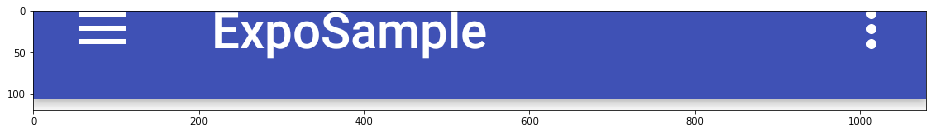

CREATE IMG


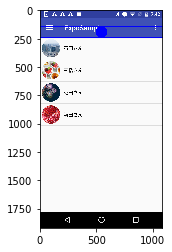

############ show rect ############
GET PARENT POS :  [0, 133]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


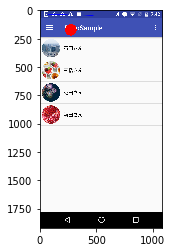

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


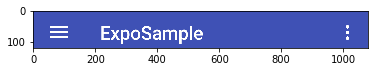

CREATE IMG


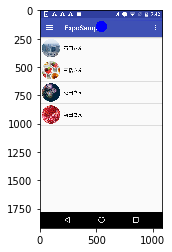

############ show rect ############
GET PARENT POS :  [0, 85]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


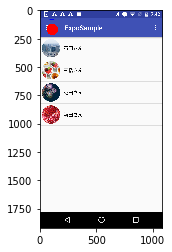

############ show rect ############
Trim IMG : x0, y507, : x1080, y567


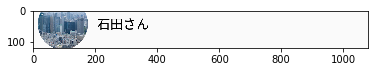

CREATE IMG


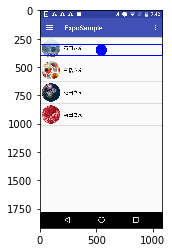

############ show rect ############
Not enough matches are found - 1/4
タップ:0,537,352,0,0,0
待機:10,10,0,0,0,0


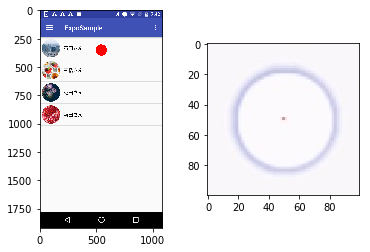

############ show rect ############
Trim IMG : x0, y502, : x1080, y562


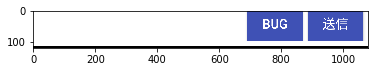

CREATE IMG


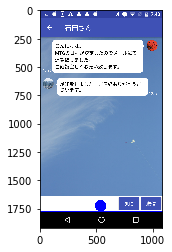

############ show rect ############
GET PARENT POS :  [0, 1663]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


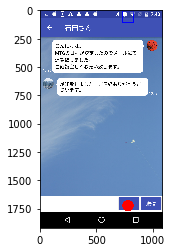

############ show rect ############
Trim IMG : x0, y487, : x1080, y547


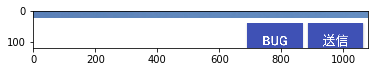

CREATE IMG


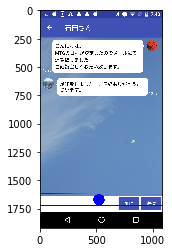

############ show rect ############
GET PARENT POS :  [0, 1610]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


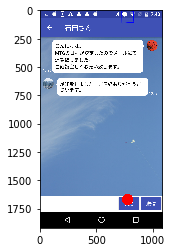

############ show rect ############
Trim IMG : x0, y505, : x1080, y565


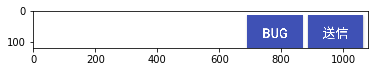

CREATE IMG


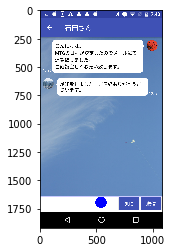

############ show rect ############
GET PARENT POS :  [0, 1634]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


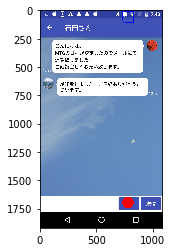

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


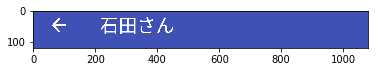

CREATE IMG


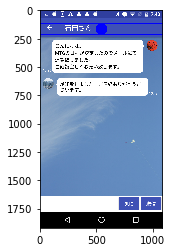

############ show rect ############
GET PARENT POS :  [0, 108]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


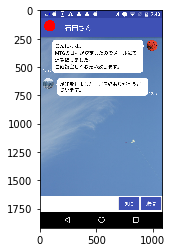

############ show rect ############
Trim IMG : x0, y507, : x1080, y567


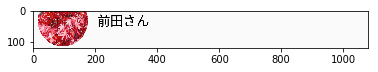

CREATE IMG


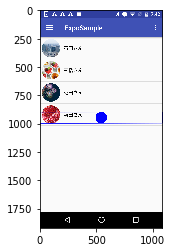

############ show rect ############
GET PARENT POS :  [0, 887]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


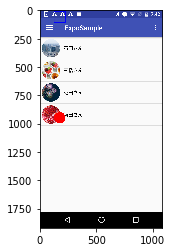

############ show rect ############
Trim IMG : x0, y511, : x1080, y571


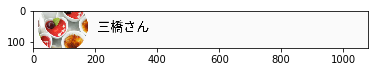

CREATE IMG


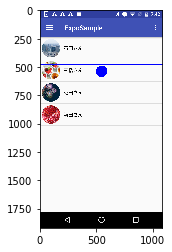

############ show rect ############
GET PARENT POS :  [0, 479]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


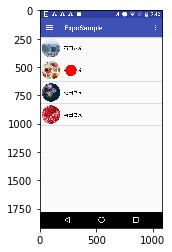

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


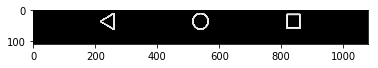

CREATE IMG


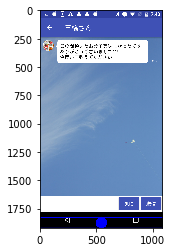

############ show rect ############
GET PARENT POS :  [0, 1812]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


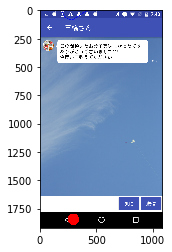

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


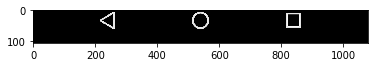

CREATE IMG


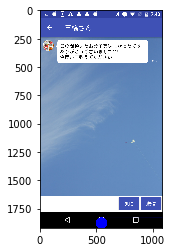

############ show rect ############
GET PARENT POS :  [0, 1815]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


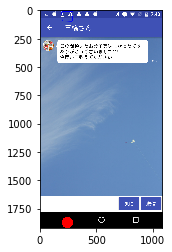

############ show rect ############
Trim IMG : x0, y431, : x1080, y491


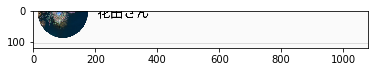

CREATE IMG


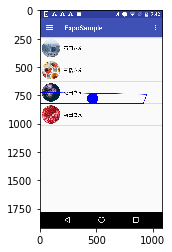

############ show rect ############
GET PARENT POS :  [0, 719]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


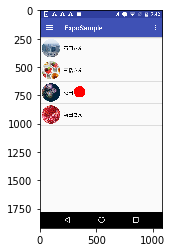

############ show rect ############
Trim IMG : x0, y508, : x1080, y568


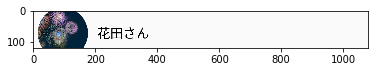

CREATE IMG


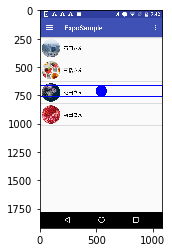

############ show rect ############
GET PARENT POS :  [0, 653]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


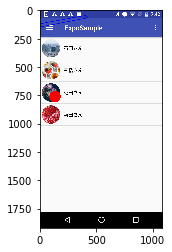

############ show rect ############
Trim IMG : x0, y1836, : x1080, y1896


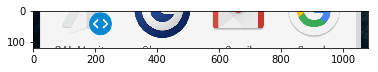

CREATE IMG


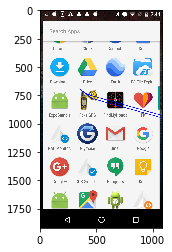

############ show rect ############
Not enough matches are found - 3/4
タップ:0,1866,1150,0,0,0
待機:10,10,0,0,0,0


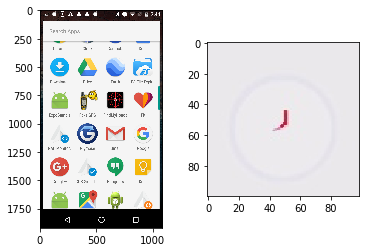

############ show rect ############
Trim IMG : x0, y358, : x1080, y418


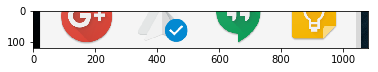

CREATE IMG


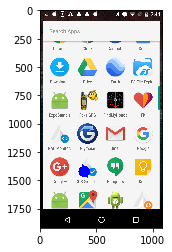

############ show rect ############
Not enough matches are found - 3/4
タップ:0,388,1422,0,0,0
待機:10,10,0,0,0,0


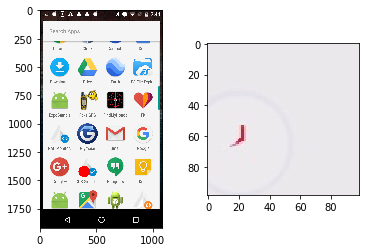

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


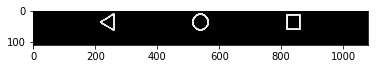

CREATE IMG


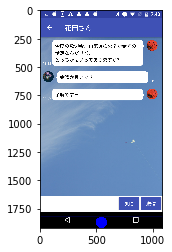

############ show rect ############
GET PARENT POS :  [0, 1810]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


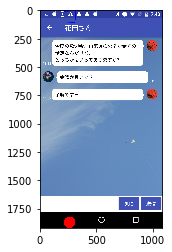

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


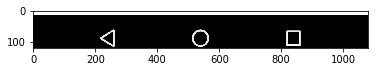

CREATE IMG


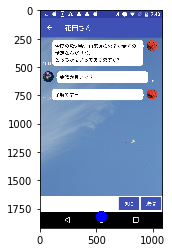

############ show rect ############
GET PARENT POS :  [0, 1759]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


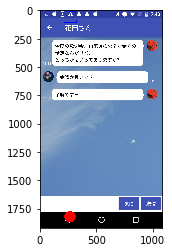

############ show rect ############
Trim IMG : x0, y71, : x1080, y131


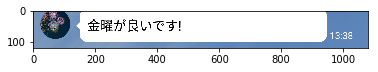

CREATE IMG


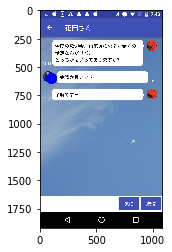

############ show rect ############
Not enough matches are found - 3/4
タップ:0,101,603,0,0,0
待機:10,10,0,0,0,0


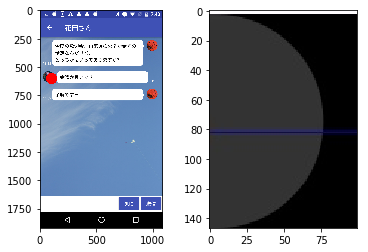

############ show rect ############
Trim IMG : x0, y362, : x1080, y422


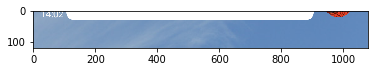

CREATE IMG


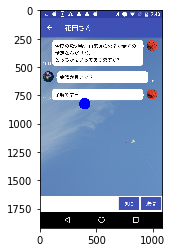

############ show rect ############
Not enough matches are found - 2/4
タップ:0,392,825,0,0,0
待機:10,10,0,0,0,0


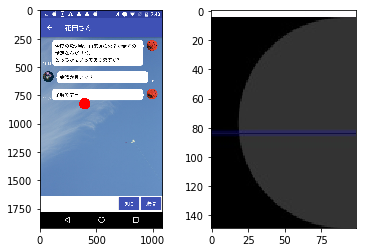

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


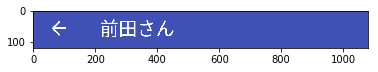

CREATE IMG


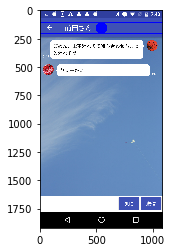

############ show rect ############
GET PARENT POS :  [0, 98]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


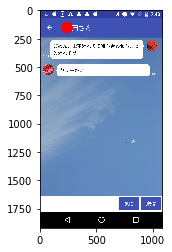

############ show rect ############
Trim IMG : x0, y512, : x1080, y572


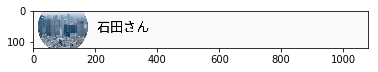

CREATE IMG


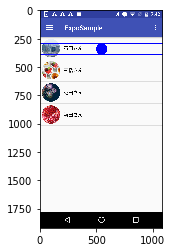

############ show rect ############
GET PARENT POS :  [0, 283]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


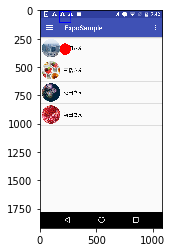

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


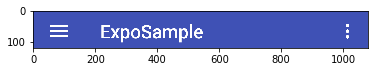

CREATE IMG


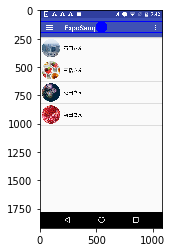

############ show rect ############
GET PARENT POS :  [0, 89]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


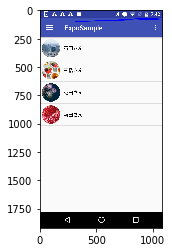

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


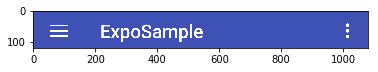

CREATE IMG


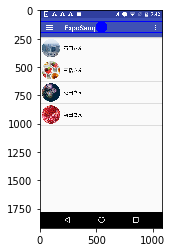

############ show rect ############
GET PARENT POS :  [0, 90]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


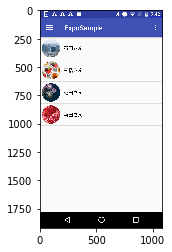

############ show rect ############
Trim IMG : x0, y506, : x1080, y566


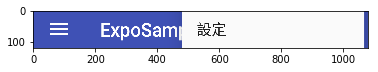

CREATE IMG


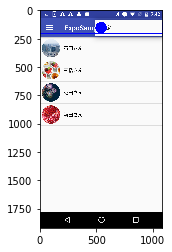

############ show rect ############
GET PARENT POS :  [0, 95]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


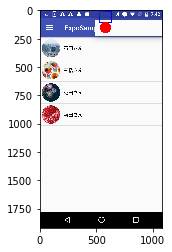

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


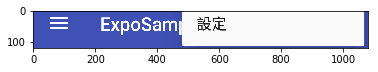

CREATE IMG


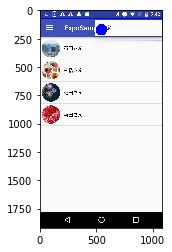

############ show rect ############
GET PARENT POS :  [0, 113]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


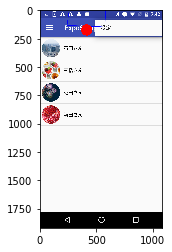

############ show rect ############
Trim IMG : x0, y548, : x1080, y608


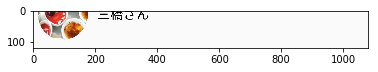

CREATE IMG


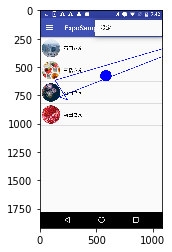

############ show rect ############
GET PARENT POS :  [0, 518]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


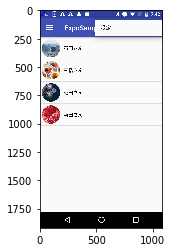

############ show rect ############
Trim IMG : x0, y118, : x1080, y178


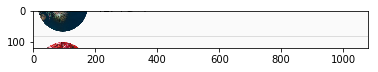

CREATE IMG


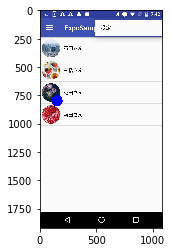

############ show rect ############
GET PARENT POS :  [0, 739]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


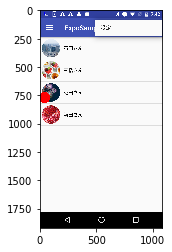

############ show rect ############
Trim IMG : x0, y626, : x1080, y686


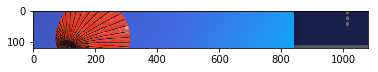

CREATE IMG


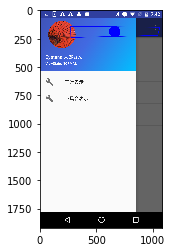

############ show rect ############
Not enough matches are found - 1/4
タップ:0,656,190,0,0,0
待機:10,10,0,0,0,0


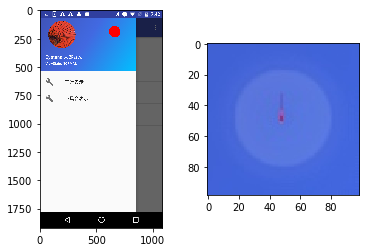

############ show rect ############
Trim IMG : x0, y746, : x1080, y806


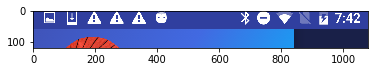

CREATE IMG


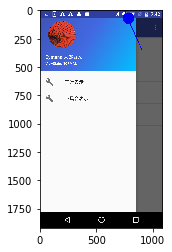

############ show rect ############
GET PARENT POS :  [0, 12]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


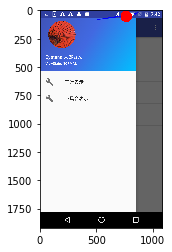

############ show rect ############
Trim IMG : x0, y767, : x1080, y827
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
Traceback (most recent call last):
  File "<ipython-input-3-18565892385a>", line 17, in <module>
    pos = cf.show_rect(IS_PARENT=True)
  File "<ipython-input-2-a396d6467f63>", line 126, in show_rect
    self.view_matplot(self.base)
  File "<ipython-input-2-a396d6467f63>", line 245, in view_matplot
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  File "/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py", line 3157, in imshow
    **kwargs)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py", line 1898, in inner
    return func(ax, *args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py", line 5124, in imshow
    im.set_data(X)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/image.py", line 596, in set_data
    raise TypeError("Image data can not convert to float

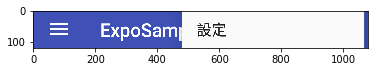

CREATE IMG


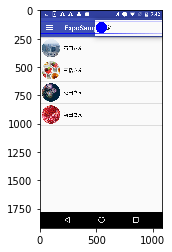

############ show rect ############
GET PARENT POS :  [0, 94]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


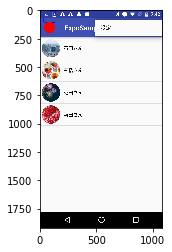

############ show rect ############
Trim IMG : x0, y487, : x1080, y547


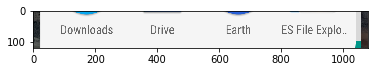

CREATE IMG


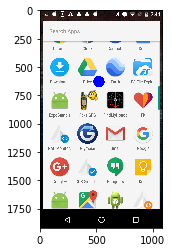

############ show rect ############
GET PARENT POS :  [0, 570]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


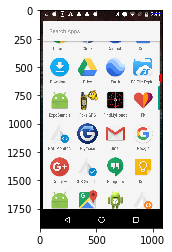

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


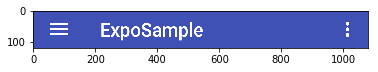

CREATE IMG


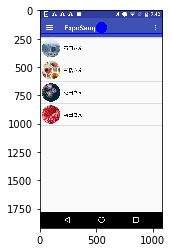

############ show rect ############
GET PARENT POS :  [0, 95]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


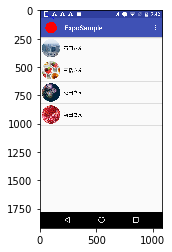

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


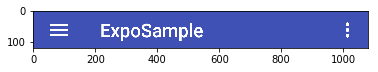

CREATE IMG


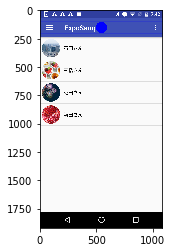

############ show rect ############
GET PARENT POS :  [0, 93]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


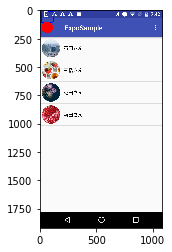

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


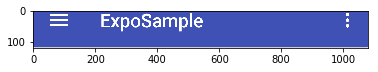

CREATE IMG


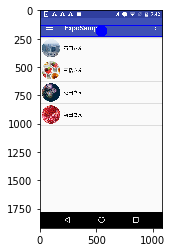

############ show rect ############
GET PARENT POS :  [0, 124]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


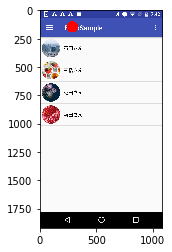

############ show rect ############
Trim IMG : x0, y58067, : x1080, y58127
############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############
Traceback (most recent call last):
  File "<ipython-input-3-18565892385a>", line 17, in <module>
    pos = cf.show_rect(IS_PARENT=True)
  File "<ipython-input-2-a396d6467f63>", line 126, in show_rect
    self.view_matplot(self.base)
  File "<ipython-input-2-a396d6467f63>", line 245, in view_matplot
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  File "/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py", line 3157, in imshow
    **kwargs)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py", line 1898, in inner
    return func(ax, *args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py", line 5124, in imshow
    im.set_data(X)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/image.py", line 596, in set_data
    raise TypeError("Image data can not convert to f

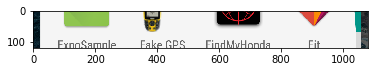

CREATE IMG


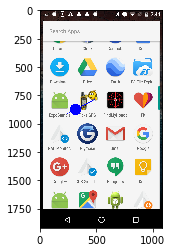

############ show rect ############
GET PARENT POS :  [0, 815]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


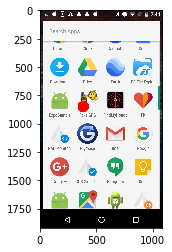

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


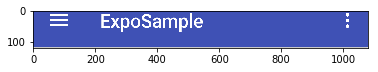

CREATE IMG


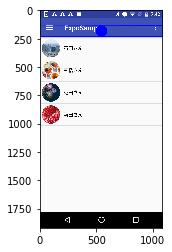

############ show rect ############
GET PARENT POS :  [0, 123]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


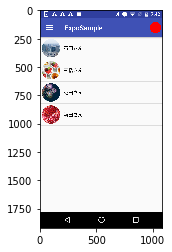

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


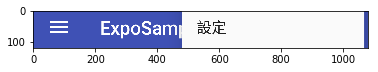

CREATE IMG


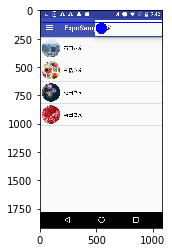

############ show rect ############
Not enough matches are found - 3/4
タップ:0,539,161,0,0,0
待機:10,10,0,0,0,0


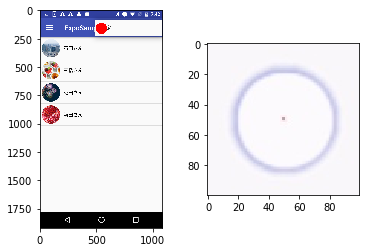

############ show rect ############
Trim IMG : x0, y221, : x1080, y281


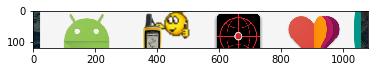

CREATE IMG


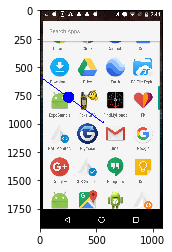

############ show rect ############
GET PARENT POS :  [0, 707]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


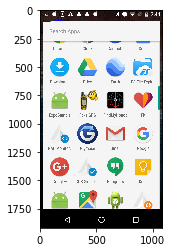

############ show rect ############
Trim IMG : x0, y469, : x1080, y529


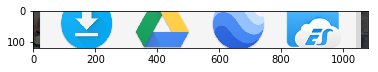

CREATE IMG


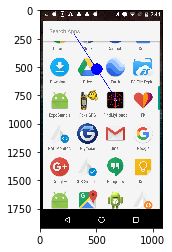

############ show rect ############
GET PARENT POS :  [0, 460]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


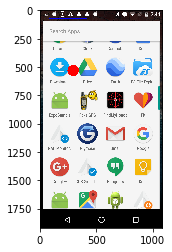

############ show rect ############
Trim IMG : x0, y516, : x1080, y576


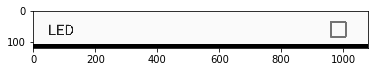

CREATE IMG


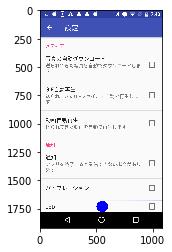

############ show rect ############
GET PARENT POS :  [0, 1670]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


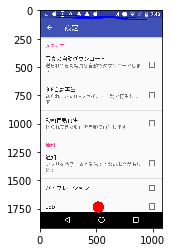

############ show rect ############
Trim IMG : x0, y517, : x1080, y577


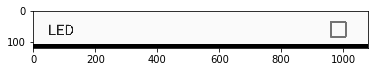

CREATE IMG


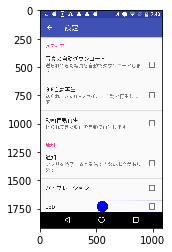

############ show rect ############
GET PARENT POS :  [0, 1670]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


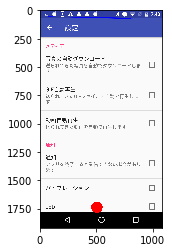

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


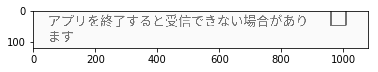

CREATE IMG


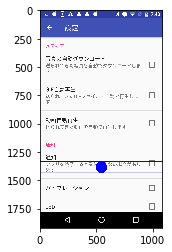

############ show rect ############
GET PARENT POS :  [0, 1325]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


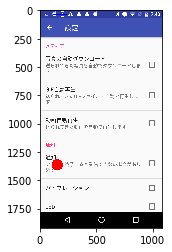

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


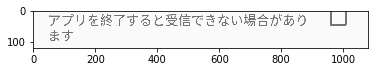

CREATE IMG


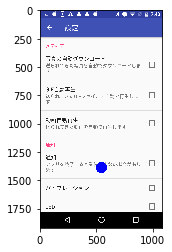

############ show rect ############
GET PARENT POS :  [0, 1327]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


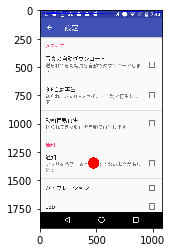

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


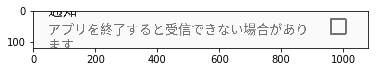

CREATE IMG


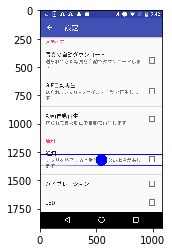

############ show rect ############
GET PARENT POS :  [0, 1262]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


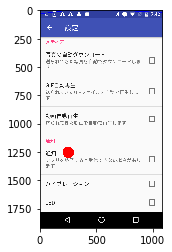

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


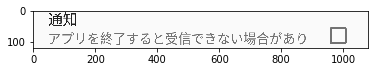

CREATE IMG


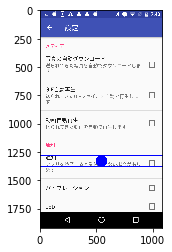

############ show rect ############
Not enough matches are found - 1/4
タップ:0,539,1329,0,0,0
待機:10,10,0,0,0,0


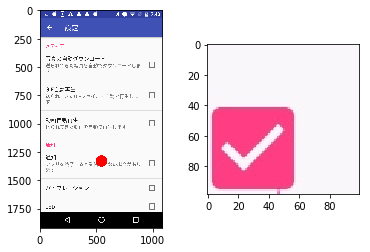

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


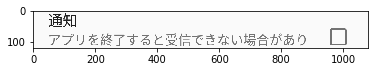

CREATE IMG


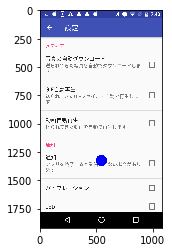

############ show rect ############
Not enough matches are found - 2/4
タップ:0,539,1325,0,0,0
待機:10,10,0,0,0,0


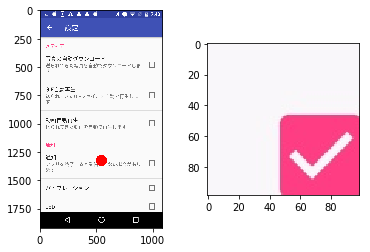

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


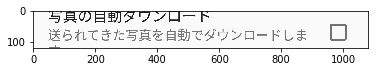

CREATE IMG


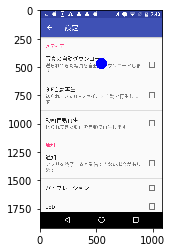

############ show rect ############
GET PARENT POS :  [0, 411]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


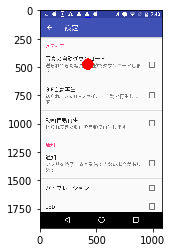

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


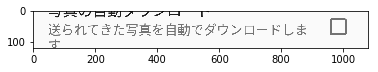

CREATE IMG


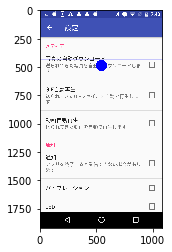

############ show rect ############
タップ:0,539,488,0,0,0
待機:10,10,0,0,0,0


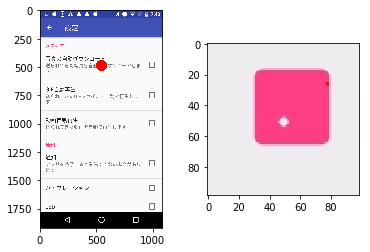

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


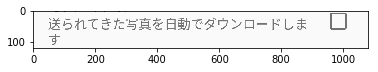

CREATE IMG


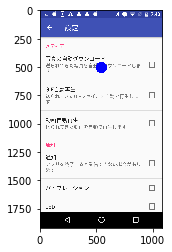

############ show rect ############
GET PARENT POS :  [0, 446]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


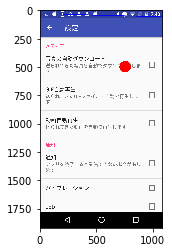

############ show rect ############
Trim IMG : x0, y509, : x1080, y569


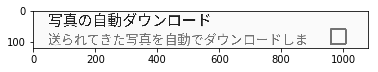

CREATE IMG


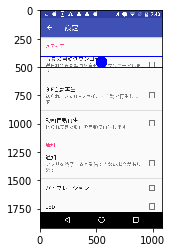

############ show rect ############
Not enough matches are found - 3/4
タップ:0,539,457,0,0,0
待機:10,10,0,0,0,0


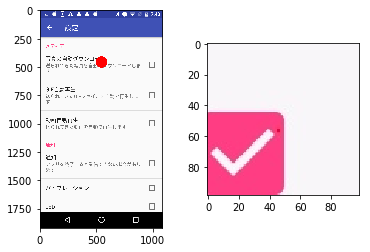

############ show rect ############
Trim IMG : x0, y517, : x1080, y577


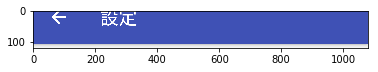

CREATE IMG


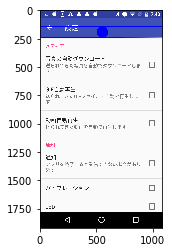

############ show rect ############
GET PARENT POS :  [0, 134]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


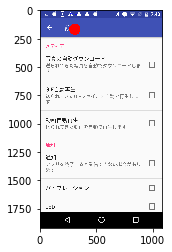

############ show rect ############
Trim IMG : x0, y510, : x1080, y570


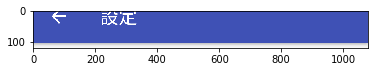

CREATE IMG


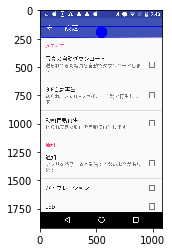

############ show rect ############
GET PARENT POS :  [0, 136]
############### TAP IMAGE!!!!!!!! ###############
CREATE IMG


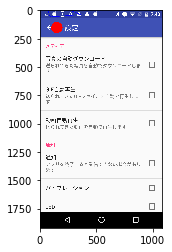

In [3]:
if __name__ == '__main__':
    f = open('base_senario.json', 'r')
    data = json.load(f)
    # print(data)
    # 解像度
    scale='#540*888#'
    print(scale)
    cf = CompareFeatures()
    for key in data:
        bs=data[key]
        try:
            pos = ()
    #         print(bs['line']['base'], " : ", bs['line']['match'])
            cf.load_imgs(bs['line']['base'],bs['line']['match'],scale=(1,bs['line']['scale']))
    #         print(type(cf.base), type(cf.match))
    #         cf.get_postion(IS_PARENT=True)
            pos = cf.show_rect(IS_PARENT=True)
    #         print("################### PARENT Finish ###################")
    #         print(bs['tap']['base'], " : ", bs['tap']['match'])
            cf.load_imgs(bs['tap']['base'],bs['tap']['match'],scale=(1,bs['tap']['scale']))
    #         print(type(cf.base), type(cf.match))

#             pos = cf.get_postion()
            pos = cf.show_rect()
        except Exception as e:
            if pos:
                print("タップ:0,{0},{1},0,0,0".format(int(pos[0]),int(pos[1])))
                print("待機:10,10,0,0,0,0")
                show_img1=cf.parent_img['base']
                show_img2=cf.match
                cv2.circle(show_img1, (int(pos[0]),int(pos[1])), 50, (0,0,255), -1)
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(show_img1, cv2.COLOR_BGR2RGB))
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(show_img2, cv2.COLOR_BGR2RGB))
                plt.show()
            else:
                print("############### !!!!!!!!!!!!!!!!!! Error !!!!!!!!!!!!!!!!!!!!!!! ###############\n{0}\n".format(traceback.format_exc()))
                pass